In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import os
import numpy as np
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
!pip install transformers -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 30.1 MB/s 
     |████████████████████████████████| 596 kB 63.1 MB/s 
     |████████████████████████████████| 101 kB 15.4 MB/s 
     |████████████████████████████████| 6.6 MB 3.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd

#Load Dataset

In [ ]:
df_train = pd.read_csv("/content/train.csv",error_bad_lines=False, engine="python")
df_test = pd.read_csv("/content/test.csv",error_bad_lines=False, engine="python")


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 9616: unexpected end of data
Skipping line 10563: unexpected end of data


In [ ]:
df_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
9609,197398a3efca11e6,"""\n\nPakistani Language (Urdu)\nUrdu in Persia...",0,0,0,0,0,0
9610,197702d8e13970d7,wikibofh reverted 3 times.,0,0,0,0,0,0
9611,197789bf80c88999,Arjun MBT\nYou can express your opinion in the...,0,0,0,0,0,0
9612,1978221458932c64,Asimova\nHi Ymblanter! You know that I edited ...,0,0,0,0,0,0


In [ ]:
train_tags = df_train.drop(['id', 'comment_text'], axis = 1)
label_counts = train_tags.sum()
df_counts = pd.DataFrame(label_counts)
df_counts.rename(columns = {0:'counts'}, inplace = True)
df_counts = df_counts.sort_values('counts', ascending = False)
df_counts

,counts
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478


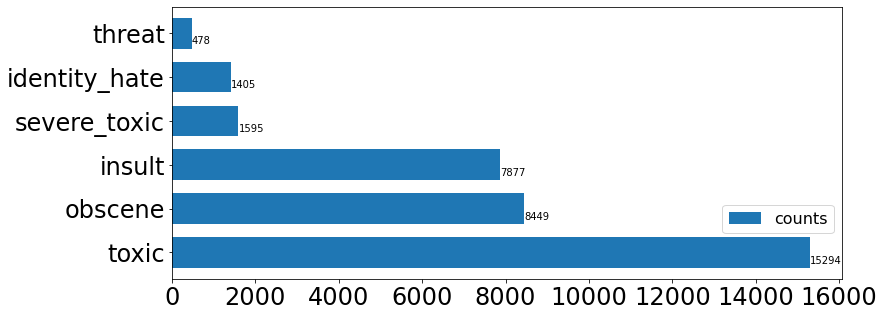

In [ ]:
ax = df_counts.plot.barh(width=0.7, fontsize='24', figsize=(12,5));
ax.legend(bbox_to_anchor=(1, 0.3), fontsize='16');
for p in ax.patches:
    w = p.get_width()
    ax.annotate(f'{w:d}', (w * 1, p.get_y() + 0.1))

#EDA

- check NaNs

In [ ]:
df_train.isnull().sum()
# we conceder in comment_text and toxic

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

- check duplicates

In [ ]:
df_train[df_train['comment_text'].duplicated()==True]
#no duplicate

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


# show samples of data texts to find out required preprocessing steps

In [ ]:
df_train[["comment_text", 'toxic']].sample(100)

,comment_text,toxic
88986,china ro2 state stasis gravity take gungho jro...,0
158803,article say military action khe sanh tactical ...,0
90394,great detective work typer525 hope find dang v...,0
113405,apparently post wp rm uncontroversial notice d...,0
36415,speedy deletion decline master lock hello sud ...,0
...,...,...
21785,image need page need good bird lekke image sho...,0
154965,david colville hi thank message add book menti...,0
139642,america rich nigger,1
6442,yeah win t let m know,0


In [ ]:

#let check sample contains not toxic
df_train[df_train["toxic"] == 0]["comment_text"].sample(10)

127745    "One or more of the children of Sonja de Lenna...
13276     I dont care! \nI dont care about what YOU say,...
53576     The page should stay without the point. Offici...
2414      "\n\nAgree. It could also be rewritten to say ...
156165    "\n\n Notes \n\nNotes on sources for the artic...
72195     I think Milo believes it is biased because it ...
131519    " I have reverted a recent edit you made to th...
18073     GunMetalAngel, Easycore is a genre, it's even ...
35121     And you can simply input the chu nom to get th...
69927     and spare me the accusations of exaggeration. ...
Name: comment_text, dtype: object

In [ ]:
#let check sample contains  toxic
df_train[df_train["toxic"] == 1]["comment_text"].sample(10)

129897    the thing is i don't need your help, especiall...
111288    Fuck You\n\nGo suck on a fat dick faggot mothe...
14349           Ignore him, Scientizzle is just an asshole.
86029                      Newsflash!!  Schuminweb is GAY!!
61921     Sound like the kind of malice and stupidity I ...
46971     Don't bother. GWH is a huge piece of shit. Jus...
83953     Intro should say that the Tea Party are a whit...
75155        MATE, are you jewish?\n\nGayness is in the air
119465    MONGO is a wanker!\n\nMONGO drinks semen while...
14069     ANTI GREEK NATIONALIS -WIKIPEDIA \n\nHi Alexik...
Name: comment_text, dtype: object

- check dataset balancing

In [ ]:
print(len(df_train[df_train.toxic==0]))
print(len(df_train[df_train.toxic==1]))
(df_train["toxic"].value_counts() / len(df_train))*100
# not balanced classification chalange

144277
15294


0    90.415552
1     9.584448
Name: toxic, dtype: float64

# So what it takes to go from the raw form to the prepared form?

__A - Text preprocessing__

1- Data sequencing: each sentence --> sequence (list) of words

2- Data cleaning: This step varies from task to task. For some tasks it's better to remove special characters and punctuations, for other they are critical (emotiocons). Good for perfromance.

3- Text normalization: in general text morphology is a big issue in NLP. Upper and lower cases, stemming and lemmatization, ...etc. Again it's task dependent.

4- Padding (model dependent): Dense and CNN. RNN can skip this step.

__B- Text preparation__

5- Binarization/vectorization/digitization: transform words into numbers according to a vocab index.

_ Remove special characters and punctuations

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# preparing data and apply all function on data

In [ ]:
df_train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
df_train = df_train.drop(["id"], axis=1)


In [ ]:
df_train

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
9609,"""\n\nPakistani Language (Urdu)\nUrdu in Persia...",0,0,0,0,0,0
9610,wikibofh reverted 3 times.,0,0,0,0,0,0
9611,Arjun MBT\nYou can express your opinion in the...,0,0,0,0,0,0
9612,Asimova\nHi Ymblanter! You know that I edited ...,0,0,0,0,0,0


In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 30.9 MB/s 


In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 25.3 MB/s 
     |████████████████████████████████| 106 kB 53.6 MB/s 


In [ ]:
import contractions# load spacy model, can be "en_core_web_sm" as well


In [ ]:
# df_test]
from bs4 import BeautifulSoup
import spacy
!python -m spacy download en_core_web_md 
nlp = spacy.load('en_core_web_md')
import unidecode


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.5 MB 2.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
def clear_text(text):
    return " ".join(re.sub("([\@|\#|\_]+)|([^0-9A-Za-z \t])", " ",text).split())
def remove_emails(text):
    return re.sub(r'\S*@\S+', '', text, flags=re.MULTILINE)
def text_preprocessing(text):
    """Remove  """ 
    text = clear_text(text)
    text = remove_emails_and_mentions(text)
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ")
    
    """remove extra whitespaces from text"""
    text = text.strip()
    text =  " ".join(text.split())

    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    
    """keep it all Lower"""
    text = text.lower()
    
    """tokenise text"""
    doc = nlp(text) 
    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text
        
        """remove stop words"""
        if token.is_stop and token.pos_ != 'NUM': 
            flag = False
            
        """remove punctuations"""    
        if token.pos_ == 'PUNCT' and flag == True: 
            flag = False
            
        """remove special characters """ 
        if token.pos_ == 'SYM' and flag == True: 
            flag = False
            
        """remove numbers"""    
        if (token.pos_ == 'NUM' or token.text.isnumeric()) \
        and flag == True:
            flag = False
            
        """convert number words to numeric numbers"""    
        if token.pos_ == 'NUM' and flag == True:
            edit = w2n.word_to_num(token.text)
            
        # convert tokens to base form     
        elif token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
            
        """append tokens edited and not removed to list """    
        if edit != "" and flag == True:
            clean_text.append(edit) 
        
    return clean_text

df_train["comment_text"] = df_train["comment_text"].apply(lambda x:' '.join(text_preprocessing(x)))

In [ ]:
df_test["comment_text"] = df_test["comment_text"].apply(lambda x:' '.join(text_preprocessing(x)))

# **TF-IDF** 

In [16]:
vectorizer = TfidfVectorizer(max_features=1000)
vectorizer.fit(pd.concat([df_train["comment_text"], df_test["comment_text"]], axis=0))

TfidfVectorizer(max_features=1000)

In [17]:
from sklearn.model_selection import train_test_split
y = df_train.iloc[:,2:]
train_words, validation_words ,train_target ,validation_target = train_test_split(df_train["comment_text"],y,test_size=0.2)


In [18]:
x_train = vectorizer.transform(train_words).toarray()
x_val = vectorizer.transform(validation_words).toarray()
x_test = vectorizer.transform(df_test["comment_text"]).toarray()

In [19]:
y_train = np.asarray(train_target).astype('float32')
y_val = np.asarray(validation_target).astype('float32')

In [39]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)

(7691, 1000)
(7691, 5)
(1923, 1000)
(1923, 5)
(10561, 1000)


In [ ]:
model = models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape=(1000,)))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(5,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                16016     
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 16,725
Trainable params: 16,725
Non-trainable params: 0
_________________________________________________________________


In [ ]:


import tensorflow as tf
import keras


model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=[metrics.binary_accuracy])

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,validation_data=(x_val, y_val))

Epoch 1/10
299/299 [==============================] - 2s 3ms/step - loss: 220.7300 - binary_accuracy: 0.7956 - val_loss: 184.8695 - val_binary_accuracy: 0.7968
Epoch 2/10
299/299 [==============================] - 1s 3ms/step - loss: 171.6834 - binary_accuracy: 0.7961 - val_loss: 141.9082 - val_binary_accuracy: 0.7968
Epoch 3/10
299/299 [==============================] - 1s 3ms/step - loss: 129.3001 - binary_accuracy: 0.7961 - val_loss: 105.3009 - val_binary_accuracy: 0.7968
Epoch 4/10
299/299 [==============================] - 1s 3ms/step - loss: 94.0474 - binary_accuracy: 0.7961 - val_loss: 74.0644 - val_binary_accuracy: 0.7968
Epoch 5/10
299/299 [==============================] - 1s 3ms/step - loss: 64.2270 - binary_accuracy: 0.7961 - val_loss: 48.7115 - val_binary_accuracy: 0.7968
Epoch 6/10
299/299 [==============================] - 1s 2ms/step - loss: 39.9573 - binary_accuracy: 0.7961 - val_loss: 28.8549 - val_binary_accuracy: 0.7968
Epoch 7/10
299/299 [==========================

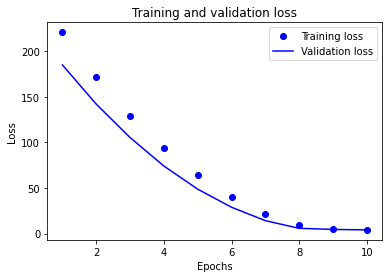

In [ ]:
history_dict = history.history
history_dict.keys()


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

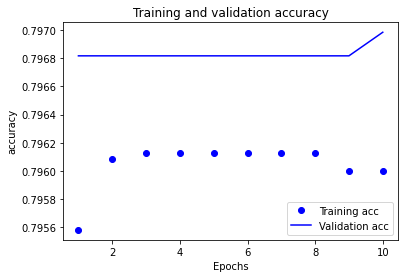

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

# LSTM


In [ ]:
len_x = len(max(train_words, key=len))
len_x

5000

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM

lstm_model = models.Sequential()
lstm_model.add(Embedding(1000, 128, input_length=1000, mask_zero=True))
lstm_model.add(LSTM(100, return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(layers.Dense(5, activation='sigmoid'))
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 128)         128000    
                                                                 
 lstm_4 (LSTM)               (None, 1000, 100)         91600     
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dense_5 (Dense)             (None, 5)                 255       
                                                                 
Total params: 250,055
Trainable params: 250,055
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.compile(optimizer=optimizers.Adam(),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
history = lstm_model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/10
19/19 [==============================] - 404s 21s/step - loss: 0.4917 - binary_accuracy: 0.9370 - val_loss: 0.2196 - val_binary_accuracy: 0.9765
Epoch 2/10
19/19 [==============================] - 384s 20s/step - loss: 0.1648 - binary_accuracy: 0.9754 - val_loss: 0.1355 - val_binary_accuracy: 0.9765
Epoch 3/10
19/19 [==============================] - 386s 20s/step - loss: 0.1314 - binary_accuracy: 0.9754 - val_loss: 0.1236 - val_binary_accuracy: 0.9765
Epoch 4/10
19/19 [==============================] - 397s 21s/step - loss: 0.1229 - binary_accuracy: 0.9754 - val_loss: 0.1160 - val_binary_accuracy: 0.9765
Epoch 5/10
19/19 [==============================] - 395s 21s/step - loss: 0.1174 - binary_accuracy: 0.9754 - val_loss: 0.1121 - val_binary_accuracy: 0.9765
Epoch 6/10
19/19 [==============================] - 386s 20s/step - loss: 0.1149 - binary_accuracy: 0.9754 - val_loss: 0.1103 - val_binary_accuracy: 0.9765
Epoch 7/10
19/19 [==============================] - 385s 20s/ste

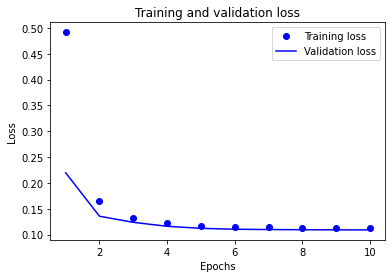

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

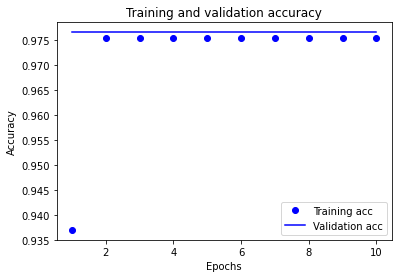

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Biderictional LSTM

In [20]:
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
Bilstm = models.Sequential()
Bilstm.add(Embedding(1000, 128, input_length=1000, mask_zero=True))
Bilstm.add(Bidirectional(LSTM(500)))
Bilstm.add(layers.Dense(5, activation='sigmoid'))


Bilstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 1000)             2516000   
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 5005      
                                                                 
Total params: 2,649,005
Trainable params: 2,649,005
Non-trainable params: 0
_________________________________________________________________


In [21]:
Bilstm.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=[metrics.binary_accuracy])
history = Bilstm.fit(x_train,
                    y_train,
                    epochs=3,
                    validation_data=(x_val, y_val))

Epoch 1/3
241/241 [==============================] - 1139s 5s/step - loss: 0.1273 - binary_accuracy: 0.9731 - val_loss: 0.1166 - val_binary_accuracy: 0.9734
Epoch 2/3
241/241 [==============================] - 1125s 5s/step - loss: 0.1120 - binary_accuracy: 0.9756 - val_loss: 0.1164 - val_binary_accuracy: 0.9734
Epoch 3/3
241/241 [==============================] - 1117s 5s/step - loss: 0.1107 - binary_accuracy: 0.9756 - val_loss: 0.1154 - val_binary_accuracy: 0.9734


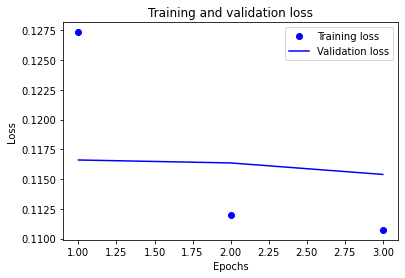

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

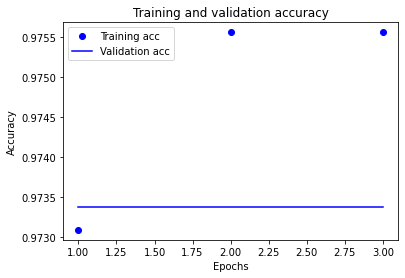

In [25]:
plt.clf()

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [42]:
Bilstm.predict(x_test)

array([[0.00681404, 0.05127471, 0.00190117, 0.04774282, 0.00360241],
       [0.01124823, 0.07600272, 0.00250651, 0.0663406 , 0.00459776],
       [0.0118629 , 0.10306311, 0.00065336, 0.10595215, 0.00753255],
       ...,
       [0.01138844, 0.06763413, 0.00329299, 0.06518128, 0.00527459],
       [0.00663675, 0.05075608, 0.00185184, 0.04707985, 0.00355354],
       [0.0061662 , 0.04940478, 0.00172165, 0.04530549, 0.00342719]],
      dtype=float32)

# GRU

In [26]:
model_GRU=models.Sequential()
model_GRU.add(Embedding(1000, 128, input_length=1000, mask_zero=True))
model_GRU.add(layers.GRU(128))
model_GRU.add(layers.Dense(64,activation='relu'))
model_GRU.add(layers.Dense(5,activation='sigmoid'))

model_GRU.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=[metrics.binary_accuracy])
history = model_GRU.fit(x_train,
                    y_train,
                    epochs=3,
                    validation_data=(x_val, y_val))

Epoch 1/3
241/241 [==============================] - 563s 2s/step - loss: 0.1288 - binary_accuracy: 0.9739 - val_loss: 0.1151 - val_binary_accuracy: 0.9734
Epoch 2/3
241/241 [==============================] - 558s 2s/step - loss: 0.1094 - binary_accuracy: 0.9756 - val_loss: 0.1126 - val_binary_accuracy: 0.9734
Epoch 3/3
241/241 [==============================] - 559s 2s/step - loss: 0.1073 - binary_accuracy: 0.9756 - val_loss: 0.1125 - val_binary_accuracy: 0.9734


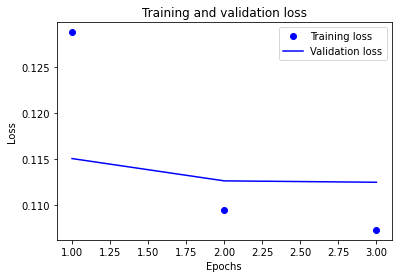

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

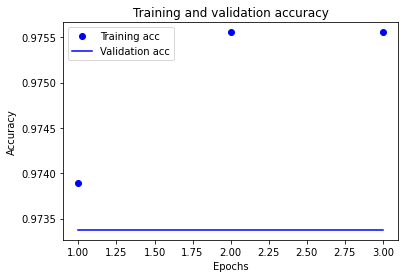

In [28]:
plt.clf()

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
model_GRU.predict(x_test)

array([[0.00257197, 0.01502161, 0.00023911, 0.01801976, 0.00213585],
       [0.01327095, 0.07440204, 0.00177959, 0.06787942, 0.00969561],
       [0.0195843 , 0.12536559, 0.00127281, 0.11022309, 0.00995565],
       ...,
       [0.00744192, 0.04198208, 0.0009396 , 0.04320109, 0.00587472],
       [0.00241296, 0.01416374, 0.00021912, 0.01710037, 0.00200628],
       [0.00199479, 0.0119533 , 0.00016849, 0.01459922, 0.00166288]],
      dtype=float32)

In [35]:
model_GRU_bi = models.Sequential()
model_GRU_bi.add(Embedding(1000, 128, input_length=1000))
model_GRU_bi.add(Bidirectional(GRU(75)))
model_GRU_bi.add(Dropout(0.2))
model_GRU_bi.add(layers.Dense(32, activation='relu'))
model_GRU_bi.add(layers.Dense(16, activation='relu'))
model_GRU_bi.add(layers.Dense(5, activation='sigmoid'))
model_GRU_bi.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1000, 128)         128000    
                                                                 
 bidirectional_5 (Bidirectio  (None, 150)              92250     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense_9 (Dense)             (None, 32)                4832      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 5)                 85        
                                                      

In [36]:

model_GRU_bi.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=[metrics.binary_accuracy])
history = model_GRU_bi.fit(x_train,
                    y_train,
                    epochs=3,
                    validation_data=(x_val, y_val))

Epoch 1/3
241/241 [==============================] - 22s 71ms/step - loss: 0.1297 - binary_accuracy: 0.9645 - val_loss: 0.1290 - val_binary_accuracy: 0.9734
Epoch 2/3
241/241 [==============================] - 16s 68ms/step - loss: 0.1089 - binary_accuracy: 0.9756 - val_loss: 0.1123 - val_binary_accuracy: 0.9734
Epoch 3/3
241/241 [==============================] - 16s 67ms/step - loss: 0.1079 - binary_accuracy: 0.9756 - val_loss: 0.1203 - val_binary_accuracy: 0.9734


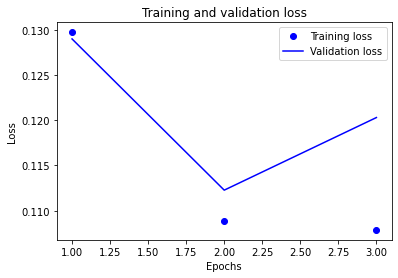

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

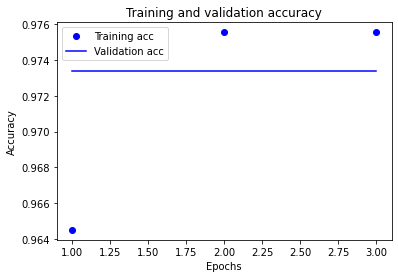

In [38]:
plt.clf()

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [40]:
model_GRU_bi.predict(x_test)

array([[0.00513334, 0.09534679, 0.01835615, 0.01822553, 0.01165222],
       [0.00513334, 0.09534679, 0.01835615, 0.01822553, 0.01165222],
       [0.00513334, 0.09534679, 0.01835614, 0.01822554, 0.01165221],
       ...,
       [0.00513334, 0.09534679, 0.01835615, 0.01822553, 0.01165222],
       [0.00513334, 0.09534679, 0.01835615, 0.01822553, 0.01165222],
       [0.00513334, 0.09534673, 0.01835614, 0.01822554, 0.01165222]],
      dtype=float32)